[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/main/tutorials/feature-use/Prophet_to_TorchProphet.ipynb)


In [18]:
# Libraries to install
# pip install pystan==2.19.1.1
# pip install prophet==1.0

# From Prophet to TorchProphet - A guide

Prophet is a popular human-in-the-loop forecasting framework build on Stan that allows to create forecasts and visualisations rapidly.

NeuralProphet is an evolution of Prophet that builds on PyTorch and supports even more forecasting components.

Since the interface of Prophet and NeuralProphet differ in various details, we build a wrapper for NeuralProphet, TorchProphet, that is 1:1 compatible with many Prophet applications.

## Disclaimer
Since TorchProphet is a wrapper for NeuralProphet, it should mainly be used for experiments and we do not encourage the use in production. It allows forecasting practitioners using Prophet to quickly evaluate the feasibility of adopting NeuralProphet.

## Comparison of Prophet and TorchProphet
Both the Prophet and the NeuralProphet model share the concept of decomposing a time series into it's components which allows a human to inspect and interprete the individual components of the forecast. Since NeuralProphet differs both in the functionality and the interface, the TorchProphet allows users to rapidly explore NeuralProphet's capabilities. In the following we will walk through the differences and similarities when working with TorchProphet instead of Prophet.

### Identical behaviour
- **Trend**
  Both Prophet and TorchProphet provide a trend component that can be predicted using `predict_trend(...)` and configured using the `changepoints` or `n_changepoints` argument during initialization.
- **Seasonality**
  Both tools allow to model seasonality by using the `add_seasonality(...)` function or providing the `yearly_seasonality`, `weekly_seasonality`, `daily_seasonality` or `seasonality_mode` argument during initialization.
- **Country holidays**
  Both tools allow to add country holidays as special events to the forecast. This is archieved by using the `add_country_holidays(...)` function.
- **Future regressors**
  Regressors can be added using the `add_regressor(...)` function in both tools.
  > **Info:** In NeurtalProphet, we differentiate between lagged and future regressors. The `add_regressor(...)` function of Prophet corresponds to the `add_future_regressor(...)` function of NeuralProphet.
- **Holidays**
  In Prophet, additional events to the country holidays can be added during initialization by passing an `holidays` argument. In NeuralProphet, this can be archieved by passing the holidays to the `add_events(...)` function. TorchProphet supports both methods.
- **Conditional seasonality**
  Conditional seasonality allows to model certain events as seasonal effects (eg. whether it's currently NFL season). This can be archieved by passing the argument `condition_name` to `add_seasonality(...)`.

### Different behaviour
- **Regularization**
  In Prophet, the argument `prior_scale` can be used to configure regularization. In TorchProphet, regularization is controlled via the `regularization` argument. `prior_scale` and `regularization` have an inverse relationship but cannot directly be translated. Thus, TorchProphet does not support regularization via `prior_scale`. Regularization is archieved via the `_reg` argument.
  ```python
  # Prophet
  from prophet import Prophet
  m = Prophet(seasonality_prior_scale=0.5)
  # Wrapper
  from neuralprophet import TorchProphet as Prophet
  m = Prophet(seasonality_reg=0.5)
  ```
- **Uncertainty**
  In Prophet, all forecasts are configured to use uncertainty intervals automatically. In NeuralProphet, the uncertaintly intervals need to be configured by the user. TorchProphet uses the default uncertainty intervals as defined in Prophet to mirror the behaviour.

  However, the uncertainty interval calculation differs between Prophet and NeuralProphet. Since Prophet uses a MAP estimate for uncertainty by default [Thread](https://github.com/facebook/prophet/issues/1124), NeuralProphet relies on quantile regression. Thus, the values are not directly comparable.
  ```python
  # Prophet
  from prophet import Prophet
  m = Prophet(interval_width=0.8)
  # Wrapper
  from neuralprophet import TorchProphet as Prophet
  m = Prophet(interval_width=0.8)
  m = Prophet(quantiles=[0.1, 0.9])
  ```


### Unsupported features in TorchProphet
- **Saturating forecasts**
  Saturating forecasts limit the predicted value to a certain limit called capacity. In Prophet, this is archieved by passing the `growth='logistic'` argument during initialization and providing a capacity limit. This functionality is currently not supported by NeuralProphet, but we plan to add support in a future version.

### Additional features of TorchProphet
- **Autoregression**
  TorchProphet allows to model autoregression of arbitrary lag lengths by building on a Neural Network implementation of the autoregression algorithm (called AR-Net). More information can be found here [Autoregression](https://neuralprophet.com/html/autoregression_yosemite_temps.html).
- **Lagged regressors**
  TorchProphet does not only support "future" regressors like in Prophet, but also lagged regressors that are simultaneous to the time series to predict. More information can be found here [Lagged covariates](https://neuralprophet.com/html/lagged_covariates_energy_ercot.html).
- **Global model**
  TorchProphet supports hierachical forecasts by training a global model on many simultaneous time series that is used to improve the performance of predicting an individual time series. More infos can be found here [Global Model](https://neuralprophet.com/html/global_modeling.html).
- **Neural Network architecture**
  TorchProphet models the forecast components using a Neural Network. By default, the network has no hidden layers. However, for more complex time series, the depth of the network can be increased to learn more complex relations.
- **PyTorch**
  TorchProphet is build on Pytorch (soon PyTorch Lightning) and thus provides interfaces for developers to extend the vanilla model for specific use cases.
- **Flexible multiplicativity**
  Multiplicativity of future regressors and seasonality can be set separately.


Due to the modularity of the code and the extensibility supported by PyTorch, any component trainable by gradient descent can be added as a module to NeuralProphet. Using PyTorch as the backend, makes the modelling process much faster compared to original Prophet which uses Stan as the backend.


## Outline
This tutorial will walk through building a simple forecasting model showing Prophet and TorchProphet code side-by-side. The code for Prophet comes from the official [Prophet quick-start tutorial](https://facebook.github.io/prophet/docs/quick_start.html#python-api).

### Data Loading

We will use the time series of the log daily page views for the Wikipedia page for Peyton Manning as example for this tutorial.

In [19]:
import pandas as pd

data_location = (
    "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/wp_log_peyton_manning.csv"
)
df = pd.read_csv(data_location)


def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0


df["nfl_sunday"] = df["ds"].apply(nfl_sunday)

### Events
Here we create a dataframe that includes the dates of all of Peyton Manning's playoff appearances.

In [20]:
playoffs = pd.DataFrame(
    {
        "holiday": "playoff",
        "ds": pd.to_datetime(
            [
                "2008-01-13",
                "2009-01-03",
                "2010-01-16",
                "2010-01-24",
                "2010-02-07",
                "2011-01-08",
                "2013-01-12",
                "2014-01-12",
                "2014-01-19",
                "2014-02-02",
                "2015-01-11",
                "2016-01-17",
                "2016-01-24",
                "2016-02-07",
            ]
        ),
        "lower_window": 0,
        "upper_window": 1,
    }
)
superbowls = pd.DataFrame(
    {
        "holiday": "superbowl",
        "ds": pd.to_datetime(["2010-02-07", "2014-02-02", "2016-02-07"]),
        "lower_window": 0,
        "upper_window": 1,
    }
)
holidays = pd.concat((playoffs, superbowls))

### Model initialisation

This is the only line of code for most applications that needs to be changed for the migration using the wrapper. We add the events dictionary and configure the seasonality.

The original code for prophet would look like this:
```python
from prophet import Prophet

p = Prophet(holidays=holidays, yearly_seasonality=20)
```

In [21]:
from neuralprophet import TorchProphet

np = TorchProphet(holidays=holidays, yearly_seasonality=20)

In [22]:
# Set loggers to ERROR level
import logging
import warnings
from neuralprophet import set_log_level


logging.getLogger("prophet").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")


set_log_level("ERROR")

### Country holidays

We add US holidays with the in built-in collection of country-specific holidays using the `add_country_holidays` method.

```python
p.add_country_holidays(country_name="US")
```

In [23]:
np.add_country_holidays(country_name="US")

### Additional regressors
We add the column `nfl_sunday` as additional regressor for the model to consider.
```python
p.add_regressor("nfl_sunday")
```

In [24]:
np.add_regressor("nfl_sunday")

### Fit forecasting models
```python
p.fit(df)
```

In [25]:
np.fit(df)

Finding best initial lr: 100%|██████████| 237/237 [00:01<00:00, 148.22it/s]


Epoch 141: 100%|██████████| 141/141 [00:00<00:00, 219.49it/s, loss=0.00487, v_num=95, MAE=0.299, RMSE=0.418, Loss=0.00539, RegLoss=0.000]  


,MAE,RMSE,Loss,RegLoss,epoch
0,2.772415,3.448696,0.499998,0.0,0
1,2.618512,3.262862,0.444688,0.0,1
2,2.414592,3.014895,0.373737,0.0,2
3,2.142352,2.679940,0.289012,0.0,3
4,1.800363,2.255965,0.197472,0.0,4
...,...,...,...,...,...
136,0.298956,0.418342,0.005421,0.0,136
137,0.299260,0.419102,0.005408,0.0,137
138,0.299494,0.418685,0.005408,0.0,138
139,0.298831,0.415729,0.005387,0.0,139


### Expand the dataset into the future
```python
future_p = p.make_future_dataframe(periods=365)
future_p["nfl_sunday"] = future_p["ds"].apply(nfl_sunday)
future_p
```

In [26]:
# Create regressor df
regressor_df = pd.DataFrame(data={"ds": pd.date_range(start=df["ds"].tail(1).values[0], periods=365, freq="D")})
regressor_df["nfl_sunday"] = regressor_df["ds"].apply(nfl_sunday)

# Create future df
future_np = np.make_future_dataframe(periods=365, regressors_df=regressor_df)
future_np

,ds,y,nfl_sunday,playoff,superbowl
0,2007-12-10,9.5908,0,0.0,0.0
1,2007-12-11,8.5196,0,0.0,0.0
2,2007-12-12,8.1837,0,0.0,0.0
3,2007-12-13,8.0725,0,0.0,0.0
4,2007-12-14,7.8936,0,0.0,0.0
...,...,...,...,...,...
3324,2017-01-14,NaN,0,0.0,0.0
3325,2017-01-15,NaN,1,0.0,0.0
3326,2017-01-16,NaN,0,0.0,0.0
3327,2017-01-17,NaN,0,0.0,0.0


### Predict future values
```python
forecast_p = p.predict(future_p)
```

In [27]:
forecast_np = np.predict(future_np.drop_duplicates(subset="ds"))
forecast_np

Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 75.68it/s]


,ds,y,yhat1,yhat1 10.0%,yhat1 90.0%,trend,season_yearly,season_weekly,events_additive,event_Christmas Day,...,Martin Luther King Jr. Day,Memorial Day,New Year's Day,New Year's Day (Observed),Thanksgiving,Veterans Day,Veterans Day (Observed),Washington's Birthday,playoff,superbowl
0,2007-12-10,9.5908,8.797554,8.507137,9.341516,7.937093,0.501571,0.358890,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2007-12-11,8.5196,8.562929,8.430205,8.915104,7.937093,0.470006,0.155831,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2007-12-12,8.1837,8.340191,8.239091,8.568979,7.937092,0.434090,-0.030991,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2007-12-13,8.0725,8.304901,8.203506,8.539286,7.937092,0.395591,-0.027781,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2007-12-14,7.8936,8.266501,8.119661,8.544015,7.937091,0.356711,-0.027301,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3323,2017-01-14,NaN,7.676910,7.474228,8.122476,7.174652,0.798687,-0.296428,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3324,2017-01-15,NaN,8.242491,7.993249,8.665323,7.173664,0.808946,-0.132220,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3325,2017-01-16,NaN,8.868060,8.536577,9.411955,7.172676,0.813289,0.358890,0.523205,0.0,...,0.523205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3326,2017-01-17,NaN,8.139615,7.903861,8.668415,7.171688,0.812097,0.155831,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Plot the forecasts
```python
fig1_p = p.plot(forecast_p)
```
![title](figures/fig1_p.png)

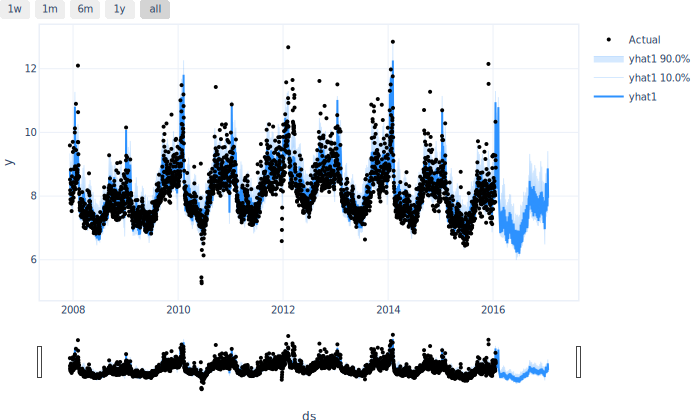

In [28]:
np.plot(forecast_np, plotting_backend="plotly-static")

### Plot the forecast components
```python
fig2_p = p.plot_components(forecast_p)
```
![title](figures/fig2_p.png)

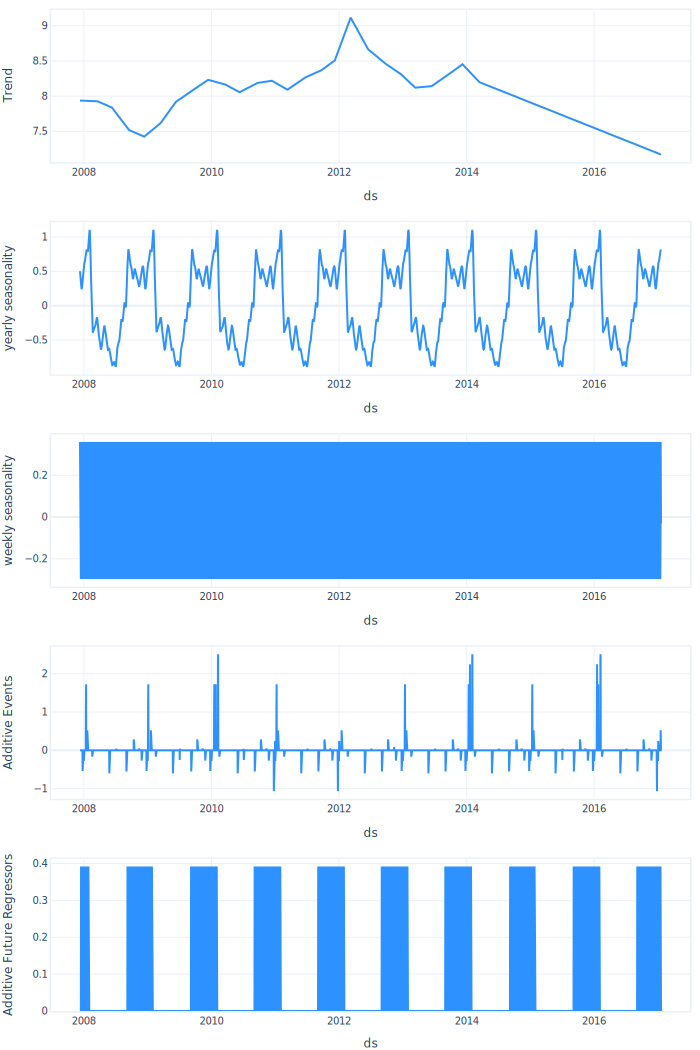

In [29]:
fig2_np = np.plot_components(forecast_np, plotting_backend="plotly-static")

### Prophet example notebook support
The following table provides an overview on the notebooks by Prophet that can be run without any further changes than changing the import of the forecasting tool from `from prophet import Prophet` to `from neuralprophet import TorchProphet as Prophet`.

| Prophet notebook  | Status  |  Comment  |
| ------------- | ------------- | ------------- |
| `additional_topics.ipynb`  | Not supported  | Additional features, specific to Prophet |
| `diagnostics.ipynb`  | Not supported  | Exploration of model components, specific to Prophet |
| `multiplicative_seasonality.ipynb`  | Supported  |  |
| `non-daily_data.ipynb`  | Supported  | Only minor plots are not supported |
| `outliers.ipynb`  | Supported  |  |
| `quick_start.ipynb`  | Supported  |  |
| `saturating_forecasts.ipynb`  | Not supported  | Saturating forecasts are not supported by NeuralProphet |
| `seasonality,_holiday_effects,_and_regressors.ipynb`  | Supported  | Events, holidays and conditional seasonality supported  |
| `trend_changepoints.ipynb`  | Supported  | Functionality supported, plots partly not supported |
| `uncertainty_intervals.ipynb`  | Supported  | Uncertainty intervals are supported, Bayesian sampling not |